# RK methods for higher-order ODEs

If we have a higher-order ODE, we can transform it into a system of first-order ODEs, which we can solve with the standard RK method.

Consider for example the ODE
$$y''(x)+P(x)y'(x)+Q(x)y(x)=F(x)\,.$$
We introduce the functions
$$w_1(x)=y(x)\,,\quad w_2(x)=y'(x)=w_1'(x)\,.$$
With this, the ODE can be written as
$$w_1'=w_2\,,\qquad w_2'=F(x)-P(x)w_2-Q(x)w_1\,.$$
In matrix form, this becomes
$$\vec{w}'=A \vec{w}+\vec{b}F(x)\quad\text{~with~}\quad A=\begin{pmatrix}0&1\\-Q(x)&-P(x)\end{pmatrix}\,,~~\vec{w}=\begin{pmatrix}w_1\\w_2\end{pmatrix}\,,~~\vec{b}=\begin{pmatrix}0\\1\end{pmatrix}$$
Now we can apply the RK method to each $w_i$ individually. For example for the first-order RK method:
$$\vec{w}(x_n+h):=\vec{w}(x_{n+1})\approx\vec{w}(x_n)+h \vec{w}'(x_n)=\vec{w}(x_n)+h(A \vec{w}(x_n)+\vec{b}F(x_n)):=\vec{w}(x_n)+h\vec{k}_1$$

## Example
$$y''(x)+4y(x)=0\,,\quad y(0)=0\,,\quad y'(0)=2$$
The exact solution is $y(x)=\sin(2x)$.

In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [14]:
def rk1(A, b, f, x_n, w_n, h=1e-2):
    k_1 = jnp.einsum('ij,j->i', A, w_n) + b * f(x_n)
    return w_n + h * k_1

In [32]:
def f(x):
    return 0
    
A = jnp.array([[0., 1.], [-4., 0.]])
b = jnp.array([0., 1.])
h=1e-2

xs = jnp.arange(0, 2 * jnp.pi, h)
ws = [jnp.array([0., 2.])]

for x, w in zip(xs, ws):
    ws.append(rk1(A, b, f, x, w, h))

ys = [w[0] for w in ws]
ys_exact = jnp.sin(2 * xs)

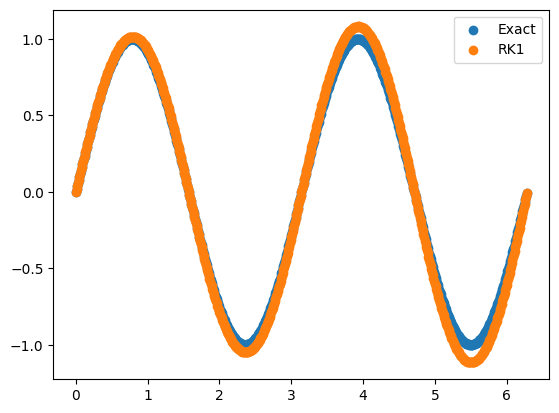

In [34]:
plt.scatter(xs, ys_exact, label="Exact");
plt.scatter(xs, ys[:-1], label="RK1");
plt.legend()